In [10]:
import pandas as pd
import matplotlib.pyplot as plt


covid_df = pd.read_csv('data/covid_df.csv')

### про круговую диаграмму

Диаграмма показывает соотношение только для десяти популярных комбинаций вакцин, а не для всех вакцин в совокупности, что является не совсем корректным для круговой диаграммы, так как она должна отображать единое целое.

К тому же наша круговая диаграмма считает количество использований каждой комбинации в таблице, а не количество стран, в которых используется эта комбинация, что также является некорректным.

*Более правильным вариантом в данном случае было бы выделить каждую вакцину в отдельности и посчитать, в скольких странах она используется*

Однако для этого нам необходимо будет совершить несколько довольно сложных преобразований:

1. Для начала нам необходимо избавиться от пропусков в столбце с вакцинами. Сделаем это с помощью метода dropna(), который удаляет строки, содержащие пропуски в столбце, указанном в параметре subset(). Данный метод мы будем изучать в следующем модуле, посвящённом очистке данных — пока что вам не стоит заострять на нём внимание:

In [2]:
combination_not_nan = covid_df.dropna(subset=['vaccines'])

2. Полученные данные необходимо сгруппировать по странам (country) и определить последнюю зафиксированную комбинации вакцин в столбце vaccines:

In [3]:
combination_last = combination_not_nan.groupby(['country'])['vaccines'].last()

В результате такого преобразования мы получаем Series, значениями которого являются комбинации вакцин, которые использовались в странах в последний день рассматриваемого периода.

In [4]:
display(combination_last)

country
Afghanistan    Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...
Albania        Oxford/AstraZeneca, Pfizer/BioNTech, Sinovac, ...
Algeria         Oxford/AstraZeneca, Sinopharm/Beijing, Sputnik V
Andorra                      Oxford/AstraZeneca, Pfizer/BioNTech
Angola                                        Oxford/AstraZeneca
                                     ...                        
Venezuela          Sinopharm/Beijing, Sinopharm/Wuhan, Sputnik V
Vietnam        Moderna, Oxford/AstraZeneca, Pfizer/BioNTech, ...
Yemen                                         Oxford/AstraZeneca
Zambia                     Oxford/AstraZeneca, Sinopharm/Beijing
Zimbabwe       Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac...
Name: vaccines, Length: 174, dtype: object

3. Преобразуем данные с помощью метода apply(): применим к столбцу lambda-функцию, в которой будем удалять из строки с комбинациями вакцин пробелы и разделять комбинацию на отдельные составляющие по запятым.

In [5]:
combination_last = combination_last.apply(lambda x: x.replace(' ', '').split(','))

В результате в каждой строке столбца получим список с отдельными вакцинами, которые используются в стране:

In [6]:
display(combination_last)

country
Afghanistan    [Johnson&Johnson, Oxford/AstraZeneca, Pfizer/B...
Albania        [Oxford/AstraZeneca, Pfizer/BioNTech, Sinovac,...
Algeria        [Oxford/AstraZeneca, Sinopharm/Beijing, SputnikV]
Andorra                    [Oxford/AstraZeneca, Pfizer/BioNTech]
Angola                                      [Oxford/AstraZeneca]
                                     ...                        
Venezuela         [Sinopharm/Beijing, Sinopharm/Wuhan, SputnikV]
Vietnam        [Moderna, Oxford/AstraZeneca, Pfizer/BioNTech,...
Yemen                                       [Oxford/AstraZeneca]
Zambia                   [Oxford/AstraZeneca, Sinopharm/Beijing]
Zimbabwe       [Oxford/AstraZeneca, Sinopharm/Beijing, Sinova...
Name: vaccines, Length: 174, dtype: object

4. Создадим словарь vaccines_dict={}, ключами которого будут являться уникальные вакцины, а значениями — количество стран, в которых они используются. Изначально словарь пустой.

5. Заполнение словаря реализуем «в лоб» — используя циклы. Во внешнем цикле будем проходиться по всем элементам Series combination_last. На каждой итерации цикла в переменной цикла vaccines_list будет находиться список вакцин, которые используются в стране.
   
Во внутреннем цикле будем проходиться по элементам этого списка, вакцинам. Переменную внутреннего цикла назовём vaccine.

В теле внутреннего цикла проверяем условие, что текущей вакцины ещё нет среди ключей словаря vaccones_dict. Если это условие выполняется, добавляем вакцину в словарь со значением 1. В противном случае увеличиваем текущее количество стран, в которых используется данная вакцина:

In [7]:
vaccines_dict = {} 
#создаём цикл по элементам Series combination_last
for vaccines_list in combination_last:
    #создаём цикл по элементам списка с вакцинами
    for vaccine in vaccines_list:
        #проверяем условие, что текущей вакцины ещё нет среди ключей словаря
        if vaccine not in vaccines_dict:#если условие выполняется
            vaccines_dict[vaccine] = 1 #заносим вакцину в словарь со значением 1
        else: #в противном случае
            vaccines_dict[vaccine] += 1 #увеличивает количество

6. В результате работы получаем словарь, который преобразуем в объект Series. Далее выделим семь наиболее популярных вакцин, а остальные обозначим как 'other'. Для этого сортируем Series по убыванию. Вычислим суммарное количество стран, в которых используются вакцины, не попавшие в наш ТОП-7, результат запишем в Series по индексу 'other'.

Далее выделим восемь наибольших значений в полученной Series — для них и будем строить круговую диаграмму.

In [8]:
vaccines = pd.Series(vaccines_dict).sort_values(ascending=False)
vaccines['other'] = vaccines[7:].sum()
vaccines = vaccines.sort_values(ascending=False)[:8]

7. Строим круговую диаграмму:

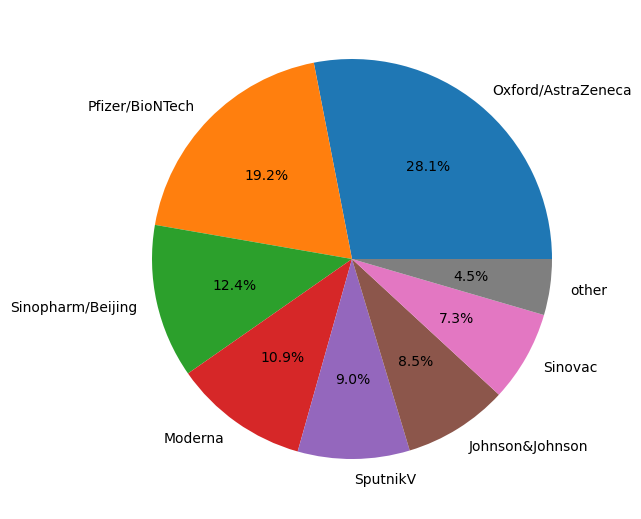

In [11]:
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    vaccines,
    labels=vaccines.index,
    autopct='%.1f%%',
);

### Полный код:

In [ ]:
#избавляемся от пропусков в столбце с вакцинами
combination_not_nan = covid_df.dropna(subset=['vaccines'])
#группируем по странам и выбираем последнюю комбинацию вакцин в стране
combination_last = combination_not_nan.groupby(['country'])['vaccines'].last() 
#заменяем пробелы в строках и делим комбинации на отдельные вакцины по запятой
combination_last = combination_last.apply(lambda x: x.replace(' ', '').split(',')) 
#создаём пустой словарь, ключами которого будут вакцины, а значениями — количество стран
vaccines_dict = {} 
#создаём цикл по элементам Series combination_last
for vaccines_list in combination_last:
    #создаём цикл по элементам списка с вакцинами
    for vaccine in vaccines_list:
        #проверяем условие, что текущей вакцины ещё нет среди ключей словаря
        if vaccine not in vaccines_dict:#если условие выполняется
            vaccines_dict[vaccine] = 1 #заносим вакцину в словарь со значением 1
        else: #в противном случае
            vaccines_dict[vaccine] += 1 #увеличивает количество
#преобразуем словарь в Series
vaccines = pd.Series(vaccines_dict).sort_values(ascending=False)
#выделяем ТОП-7 вакцин и добавляем категорию 'other'
vaccines['other'] = vaccines[7:].sum()
vaccines = vaccines.sort_values(ascending=False)[:8]
#строим круговую диаграмму
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    vaccines,
    labels=vaccines.index,
    autopct='%.1f%%',
);